<a href="https://colab.research.google.com/github/jakubtwalczak/Muller_Guido_Introduction_to_ML/blob/main/Rozdzia%C5%82_6_%C5%81a%C5%84cuchy_algorytm%C3%B3w_i_potoki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Większość aplikacji do uczenia maszynowego wymaga nie tylko zastosowania pojedynczego algorytmu, ale również połączenia wielu etapów przetwarzania danych i modeli. Uprościć ten proces można, implementując łańcuch transformacji - tzw. potok. Tworzenie łańcuchów transformacji i modeli jest możliwe dzięki użyciu klasy Pipeline.

Poniżej przykład dzielenia danych, obliczania minimum i maksimum, skalowania danych i treningu modelu - zbiór danych Cancer, klasyfikator SVM.

In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
svm = SVC()
svm.fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.97


# Wybór parametrów z przetwarzaniem wstępnym.

Gdy chcemy znaleźć najlepsze parametry dla modelu, używając klasy GridSearchCV, naiwne podejście do tego może wyglądać następująco:

In [2]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=10)
grid.fit(X_train_scaled, y_train)
print(f"Best cross-validation score: {grid.best_score_:.2f}")
print(f"Test set score: {grid.score(X_test_scaled, y_test):.2f}")
print(f"Best parameters: {grid.best_params_}")

Best cross-validation score: 0.98
Test set score: 0.97
Best parameters: {'C': 1, 'gamma': 1}


Aby się dowiedzieć, jak przeskalować dane, użyliśmy wszystkich danych ze zbioru treningowego. Następnie, aby przeprowadzić przeszukiwanie siatki, skorzystaliśmy z przeskalowanych danych uczących. Część testowa służy do zmierzenia, jak nowe dane będą wyglądały w modelu wytrenowanym w części uczącej. Jednak już skalując dane, użyliśmy informacji zawartych w podzbiorze testowym, jako że te dane były wykorzystane w procesie kroswalidacji. Podzbiór testowy w każdym podziale walidacji krzyżowej jest częścią zbioru treningowego, a żeby znaleźć właściwe skalowanie danych, sięgnęliśmy po informacje z całego zbioru uczącego.

Różni się to od tego, jak nowe dane przedstawiają się w modelu. Jeżeli zaobserwujemy nowe dane, nie zostaną one wykorzystane do skalowania danych uczących; mogą mieć inne minimum i maksimum niż dane uczące.

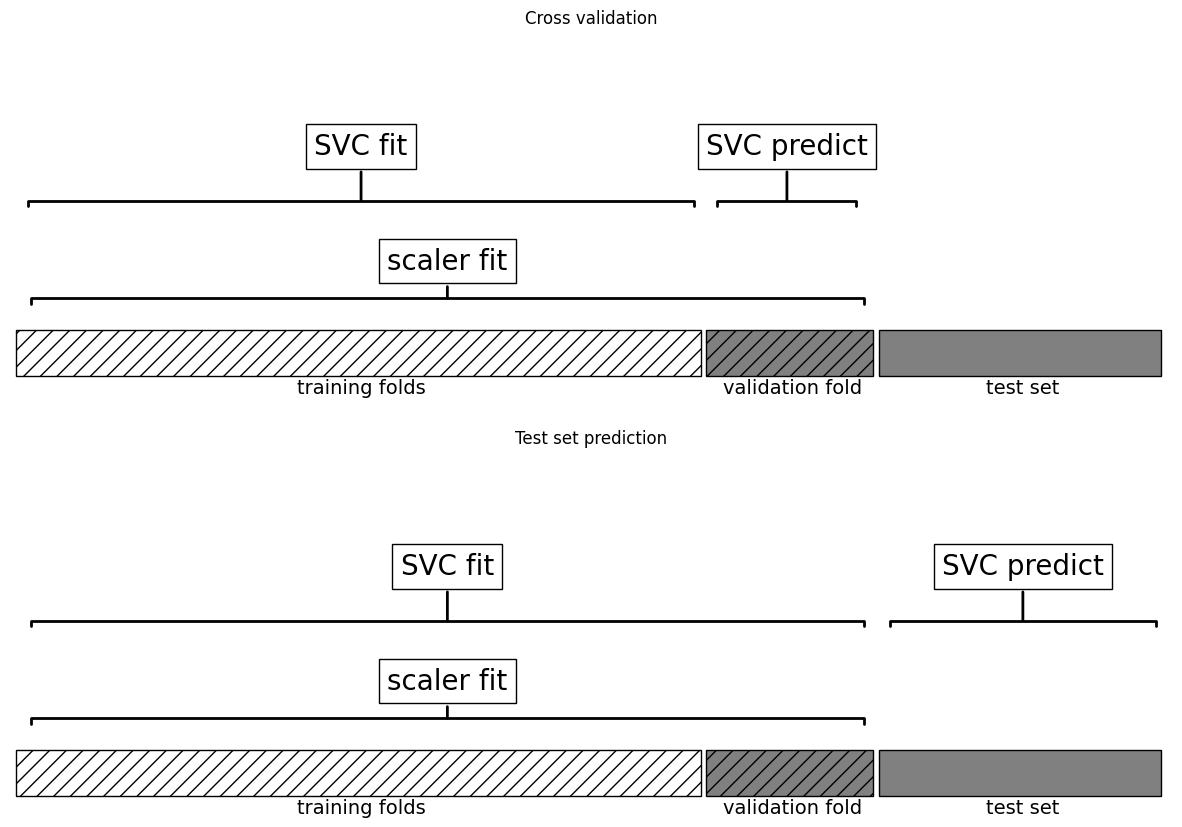

In [3]:
import mglearn

mglearn.plots.plot_improper_processing()

Podziały w walidacji krzyżowej nie odzwierciedlają już poprawnie wyglądu nowych danych w procesie modelowania. Informacje z tych danych przeciekły już do procesu modelowania, przez co wynik walidacji krzyżowej jest zbyt optymistyczny i zapewne doprowadzi do wyboru nieoptymalnych parametrów.

Żeby ten problem obejść, należy podzielić dane przed wykonaniem jakiegokolwiek przetwarzania wstępnego. Każdy proces wyodrębniający wiedzę z danych, powinien być stosowany wyłącznie na danych uczących. Walidacja krzyżowa powinna być "najbardziej zewnętrzną pętlą" przetwarzania.

Aby to osiągnąć, przy użyciu walidacji krzyżowej i przeszukiwania siatki możemy użyć klasy Pipeline. Pozwala ona na "sklejanie" wielu etapów przetwarzania w jeden estymator.

# Tworzenie potoków.

Potok tworzymy jako instancję klasy Pipeline z listą kroków, przekazywanych jako krotkę, która zawiera nazwę oraz instancję estymatora. Zdefiniowaliśmy dwa kroki - pierwszy zawiera nazwę "scaler" i instancję klasy MinMaxScaler, drugi - nazwę "svm" i instancję klasy SVC. Na takim obiekcie możemy wywołać metodę fit; powoduje ona wywołanie metody fit dla wszystkich kroków potoku. Aby ocenić dane testowe, wywołujemy metodę score.

In [4]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])
pipe.fit(X_train, y_train)
print(f"Test score: {pipe.score(X_test, y_test):.2f}")

Test score: 0.97


Metoda score dla obiektu klasy Pipeline najpierw spowodowała przeskalowanie danych przy użyciu skalera, a następnie wywołanie metody score dla modelu SVM przy użyciu przeskalowanych danych testowych. Przy pomocy potoku redukujemy kod potrzebny do procesu przekształcenia wstępnego i modelowania. Główną zaletą korzystania zeń jest jednak to, że możemy użyć tego pojedynczego estymatora w funkcji cross_val_score lub w klasie GridSearchCV.

# Używanie potoków do przeszukiwania siatki.

Potoków w celu przeszukiwania siatki używamy tak samo jak każdego innego estymatora. Definiujemy siatkę parametrów do przeszukania i konstruujemy obiekt GridSearchCV z potoku i siatki. Musimy jednak określić dla każdego parametru, do którego kroku potoku ona należy. Nazwa siatki parametrów dla potoku składa się z określonej dla każdego parametru nazwy kroku, podwójnego podkreślnika i nazwy parametru. Aby przeszukać parametr C klasy SVC, musimy użyć ciągu znaków "svm__C" jako klucza w słowniku siatki i podobnie dla parametru gamma.

In [5]:
param_grid = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print(f"Best cross-validation score: {grid.best_score_:.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best parameters: {grid.best_params_}")

Best cross-validation score: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


W przeciwieństwie do przeszukiwania siatki przeprowadzonego wcześniej, tym razem dla każdej części danych z podziału w kroswalidacji skaler jest ponownie dopasowywany przy użyciu danych wyłącznie z części podziału z danymi uczącymi. Żadne informacje nie wyciekają do wyszukiwania parametrów z części testowej modelu.

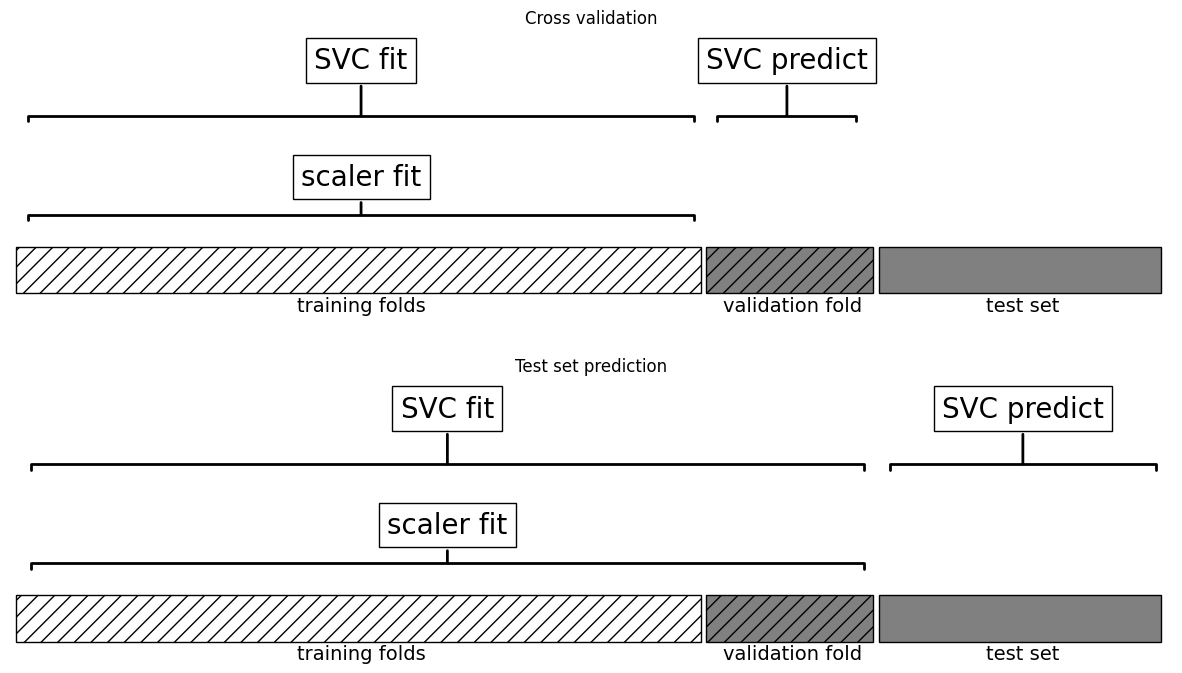

In [6]:
mglearn.plots.plot_proper_processing()

Wpływ wycieku informacji w kroswalidacji jest różny, zależnie od charakteru etapu przetwarzania wstępnego. Szacowanie skali danych przy użyciu podzbioru testowego nie prowadzi zazwyczaj do drastycznych różnic w wynikach, ale użycie go do wyodrębniania i wyboru cech potrafi mieć bardzo złe skutki.

A oto przykład na wyciek informacji podczas walidacji krzyżowej. Mamy zadanie regresji ze 100 syntetycznymi próbkami i 10000 cech próbkowanych niezależnie od rozkładu Gaussa, próbkujemy również odpowiedź z rozkładu Gaussa.

In [7]:
import numpy as np

rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

Zbiór danych utworzyliśmy tak, że nie ma związku między danymi X i celem y, więc nie powinno być możliwości nauczenia modelu czegokolwiek z tych danych. Wybierzemy jednak najbardziej "pouczające" 5% cech za pomocą selekcji SelectPercentile, a następnie przy pomocy walidacji krzyżowej ocenimy regresję grzbietową Ridge.

In [8]:
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print(f"X_selected.shape: {X_selected.shape}")
print(f"Cross validation score (only CV for Ridge): {np.mean(cross_val_score(Ridge(), X_selected, y, cv=5)):.2f}")

X_selected.shape: (100, 500)
Cross validation score (only CV for Ridge): 0.91


Średnia wartość R^2 wynosi 0,91, co wskazywałoby na bardzo dobry model. To jednak nie jest poprawne, gdyż nasze dane są całkowicie losowe. Metoda wyboru cech wyznaczyła te z losowo wygenerowanych cech, które są - zupełnym przypadkiem - bardzo dobrze skorelowane ze zmienną zależną. Ponieważ dopasowujemy wybór cechy poza walidacją krzyżową, może on znaleźć cechy skorelowane w danych podzbiorów zarówno uczących, jak i testowych.

Informacje, które wyciekły z podzbiorów testowych, były bardzo pouczające, co doprowadziło do bardzo nierealistycznych rezultatów. Porównajmy to do odpowiednio przeprowadzonej walidacji krzyżowej, wykonanej za pomocą potoku.

In [9]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression, percentile=5)),
                  ("ridge", Ridge())])
print(f"Cross validation score (Pipeline): {np.mean(cross_val_score(pipe, X, y, cv=5)):.2f}")

Cross validation score (Pipeline): -0.25


Tym razem współczynnik determinacji był ujemny, co wskazuje na bardzo słaby model. Wybór cechy znalazł się w pętli walidacji krzyżowej, dzięki temu, że wykorzystaliśmy potok. Oznacza to, że cechy można wybierać tylko przy użyciu podzbiorów uczących, a nie również testowych. Wybór cech pozwala znaleźć te z nich, które są skorelowane z celem w zbiorze uczącym, ale ponieważ dane są całkowicie losowe, cechy nie są skorelowane z celem w zbiorze danych testowych. Przykład ten demonstruje, że naprawa problemu wycieku danych powoduje różnicę między stwierdzeniem, że model działa bardzo dobrze, a stwierdzeniem, że nie działa wcale.

# Ogólny interfejs potoku.

Klasa Pipeline może łączyć również ze sobą dowolną liczbę estymatorów. Możliwe jest zbudowanie potoku, który zawiera wyodrębnianie cech, wybór cechy, skalowanie i model dla odpowiedniego zadania (klasyfikacja, regresja, klasteryzacja). Jedynym wymaganiem jest to, aby wszystkie kroki poza ostatni miały metodę transform i mogły uformować taką reprezentację danych, której można użyć w ostatnim kroku.

Wywołanie metody fit dla klasy Pipeline skutkuje wywołaniem dla każdego kolejnego kroku metody fit, a następnie transform, przy czym danymi wejściowymi są dane po transformacji z poprzedniego kroku. Na ostatnim etapie wywoływana jest metoda fit. Atrybut steps zawiera listę krotek składających się na potok.

In [10]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        X_transformed = estimator.fit_transform(X_transformed, y)
    self.steps[-1][1].fit(X_transformed, y)
    return self

Podczas prognozowania za pomocą potoku przekształcamy dane w sposób podobny, używając metody transform w każdym kroku oprócz ostatniego, w którym stosujemy metodę predict.

In [11]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        X_transformed = step[1].transform(X_transformed)
    return self.steps[-1][1].predict(X_transformed)

Potok może być jeszcze bardziej ogólny; nie ma wymagania, aby ostatni krok posiadał funkcję predict. Można utworzyć potok zawierający np. skaler i PCA. Aby uzyskać dane wyjściowe metody PCA.transform zastosowanej do przetworzonych przez poprzedni krok danych, możemy wywołać metodę transform w potoku. Wymaganiem do ostatniego kroku potoku jest tylko to, aby była w nim zaimplementowana metoda fit.

Tworzenie potoku może być znacznie łatwiejsze pod względem składni przy zastosowaniu funkcji make_pipeline, która utworzy dla nas potok i automatycznie nazwie każdy krok na podstawie jego klasy.

In [12]:
from sklearn.pipeline import make_pipeline
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

Oba utworzone obiekty robią dokładnie to samo. Różnią się tym, że pipe_short posiada kroki z nazwami nadanymi automatycznie, a nie predefiniowanymi. Nazwy kroków przechowuje atrybut steps; są to nazwy klas zapisane małymi znakami, przy czym, jeśli kilka kroków ma tę samą nazwę, dołączana jest liczba.

In [13]:
print(f"Pipeline steps: {pipe_short.steps}")

Pipeline steps: [('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print(f"Pipeline steps:\n{pipe.steps}")

Pipeline steps:
[('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


Zdarza się często, że trzeba sprawdzić jeden z atrybutów potoku. Najłatwiejszym sposobem sprawdzenia jest użycie atrybutu named_steps, który przyjmuje formę słownika z kluczami w postaci nazw kroków i wartościami w postaci estymatorów.

In [15]:
pipe.fit(cancer.data)
components = pipe.named_steps["pca"].components_
print(f"components.shape: {components.shape}")

components.shape: (2, 30)


Jednym z głównych powodów stosowania potoków jest przeszukiwanie siatki, a częstym zadaniem jest uzyskanie dostępu do niektórych kroków potoku. Przeszukajmy siatkę klasyfikatora LogisticRegression na zbiorze danych Cancer, z użyciem klasy Pipeline i StandardScaler do skalowania danych przed przekazaniem ich do klasyfikatora.

Najpierw stwórzmy potok. Zdefinieujemy też siatkę parametrów - dla regresji logistycznej sprawdzimy parametr C, regulujący siłę regularyzacji.

In [16]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

Podzielmy teraz zbiór danych Cancer na treningowy i testowy, a następnie dopasujmy przeszukiwanie siatki.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

Dostęp do najlepszego modelu zapewnia nam oczywiście atrybut best_estimator_ dla siatki.

In [18]:
print(f"Best estimator:\n{grid.best_estimator_}")

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1))])


Aby uzyskać dostęp do kroku LogisticRegression, możemy użyć atrybutu named_steps dla potoku, jak już wyjaśniono wcześniej.

In [19]:
print(f"LogisticRegression step:\n{grid.best_estimator_.named_steps['logisticregression']}")

LogisticRegression step:
LogisticRegression(C=1)


Jako że mamy wyszkoloną instancję klasy LogisticRegression, możemy przyjrzeć się współczynnikom (wagom) skojarzonych z każdą cechą wejściową.

In [20]:
print(f"LogisticRegression coefficients:\n{grid.best_estimator_.named_steps['logisticregression'].coef_}")

LogisticRegression coefficients:
[[-0.4475566  -0.34609376 -0.41703843 -0.52889408 -0.15784407  0.60271339
  -0.71771325 -0.78367478  0.04847448  0.27478533 -1.29504052  0.05314385
  -0.69103766 -0.91925087 -0.14791795  0.46138699 -0.1264859  -0.10289486
   0.42812714  0.71492797 -1.08532414 -1.09273614 -0.85133685 -1.04104568
  -0.72839683  0.07656216 -0.83641023 -0.64928603 -0.6491432  -0.42968125]]
